**Name:** Yara Elzahy

**ID:** 20398570

In [16]:
import numpy as np
import matplotlib.pyplot as plt

### Define The Environment

In [17]:
class WindyGridWorld:
    def __init__(self, wind,king = False ):
        self.grid = np.zeros((7, 10))  # Initialize the grid with zeros
        self.wind = wind  # Set the wind pattern
        self.current_state = [3, 0]  # Set the starting state
        self.king = king

    def step(self, action):
        x, y = self.current_state
        
        new_step = 0 if (self.king == False) else np.random.choice([0,1,-1])
        
        if action == 0:  # up
            x = min(max(x - self.wind[y] - 1  + new_step, 0),6)
        elif action == 1:  # down
            x = min(max(x + 1 + new_step,0), 6)
            
        elif action == 2:  # left
            x = min(max(x - self.wind[y]+ new_step, 0),6)
            y = min(max(y - 1, 0),9)
                
        elif action == 3:  # right
            x = min(max(x - self.wind[y]+ new_step, 0),6)
            y = max(min(y + 1, 9),0)
            
        elif action == 4:  # up-right
            x = min(max(x - self.wind[y] - 1+ new_step, 0),6)
            y = max(min(y + 1, 9),0)
            
        elif action == 5:  # down-right
            x = max(min(x + 1+ new_step, 6),0)
            y = max(min(y + 1, 9),0)
            
        elif action == 6:  # down-left
            x = max(min(x + 1+ new_step, 6),0)
            y = min(max(y - 1, 0),9)
            
        elif action == 7:  # up-left
            x = min(max(x - self.wind[y] - 1+ new_step, 0),6)
            y = min(max(y - 1, 0),9)
            
            
        self.current_state = [x, y]  # Update the current state
        if self.current_state == [3, 7]:  # Check if the goal state is reached
            return self.current_state, 0, True
        else:
            return self.current_state, -1, False

    def reset(self):
        self.current_state = [3, 0]  # Reset the state to the starting state
        return self.current_state

    def plot_policy(self, optimal_policy, num_actions):
        if num_actions == 4:
            arrows = ['↑', '↓', '←', '→']
            arrow_colors = ['black'] * 4
        elif num_actions == 8:
            arrows = ['↑', '↓', '←', '→', '↗', '↘', '↙', '↖']
            arrow_colors = ['black'] * 8
        else:
            raise ValueError("Invalid number of actions. Supported values are 4 and 8.")

        start_goal_color = 'navy'
        path_color = 'yellow'

        plt.figure(figsize=(7, 6))
        ax = plt.gca()
        ax.set_xticks(np.arange(0.5, 10.5, 1))
        ax.set_yticks(np.arange(0.5, 7.5, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.xlim([0, 10])
        plt.ylim([0, 7])

        # Create a gradient of blue colors for the background
        gradient = np.linspace(0, 1, 256).reshape(1, -1)
        plt.imshow(gradient, cmap='cool', aspect='auto', extent=[0, 10, 0, 7], alpha=0.8)

        # Plot optimal policy arrows
        for i in range(7):
            for j in range(10):
                action = optimal_policy[i, j]
                arrow = get_arrow_string(action)
                color = arrow_colors[action]
                plt.text(j + 0.5, i + 0.5, arrow, ha='center', va='center', color=color, fontsize=20, fontweight='bold')

        # Plot start and goal
        plt.text(0.5, 3.5, 'S', ha='center', va='center', fontsize=22, fontweight='bold', color=start_goal_color)
        plt.text(7.5, 3.5, 'G', ha='center', va='center', fontsize=22, fontweight='bold', color=start_goal_color)

        # Plot path from start to goal
        path = self.find_path(optimal_policy)
        x_coords = [state[1] + 0.5 for state in path]
        y_coords = [state[0] + 0.5 for state in path]
        plt.plot(x_coords, y_coords, color=path_color, linewidth=3)

        plt.show()


    def find_path(self, optimal_policy):
        path = []
        state = [3, 0]
        visited_states = set()  # Track visited states
        while state != [3, 7] and tuple(state) not in visited_states:  # Convert state to tuple
            visited_states.add(tuple(state))  # Add current state to visited states
            path.append(state)
            action = optimal_policy[state[0], state[1]]
            state, _, _ = self.step(action)
        path.append([3, 7])
        return path


### Define the agent

In [18]:
class Agent:
    def __init__(self, actions, alpha, epsilon):
        self.actions = actions  # Set the available actions
        self.Q = np.zeros((7, 10, len(actions)))  # Initialize the Q-values to zero
        self.epsilon = epsilon  # Set the exploration rate
        self.alpha = alpha  # Set the learning rate
        self.gamma = 1  # Set the discount factor
        

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:  # Epsilon-greedy policy for exploration
            action = np.random.choice(self.actions)
        else:
            action = np.argmax(self.Q[state[0], state[1], :])
        return action
    
    def learn(self, state, action, reward, next_state, next_action, done):
        predict = self.Q[state[0], state[1], action]  # Get the current Q-value for the state-action pair
        if done:
            target = reward  # If the episode is over, set the target to the reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state[0], next_state[1], :])  # Calculate the target using the Bellman equation
        self.Q[state[0], state[1], action] += self.alpha * (target - predict)  # Update the Q-value using the TD error

### Define the algorithms

#### 1) SARSA Algorithm

In [ ]:
# This function implements the SARSA algorithm
def sarsa(agent, env, episodes):
    sarsa_steps_per_episode = []
    prev_optimal_policy = None
    for episode in range(episodes):
        state = env.reset()  # Reset the environment to the starting state
        action = agent.choose_action(state)
        steps = 0
        while True:
            next_state, reward, done = env.step(action)  # Take a step in the environment
            next_action = agent.choose_action(next_state)
            agent.learn(state, action, reward, next_state, next_action, done)  # Update the Q-value
            state = next_state
            action = next_action
            steps += 1
            if done:  # If the episode is over, record the number of steps taken and break out of the loop
                sarsa_steps_per_episode.append(steps)
                break
        
        # Check if the optimal policy has been reached
        current_optimal_policy = np.argmax(agent.Q, axis=2)
        if np.array_equal(current_optimal_policy, prev_optimal_policy):
            print("SARSA has converged")
            break
        prev_optimal_policy = current_optimal_policy
        
    return sarsa_steps_per_episode

#### 2) Q-Learning Algorithm

In [ ]:
# This function implements the Q-Learning algorithm
def q_learning(agent, env, episodes):
    q_learning_steps_per_episode = []
    prev_optimal_policy = None
    for episode in range(episodes):
        state = env.reset()  # Reset the environment to the starting state
        action = agent.choose_action(state)
        steps = 0
        while True:
            next_state, reward, done = env.step(action)  # Take a step in the environment
            next_action = np.argmax(agent.Q[next_state[0], next_state[1], :])
            agent.learn(state, action, reward, next_state, next_action, done)  # Update the Q-value
            state = next_state
            action = next_action
            steps += 1
            if done:  # If the episode is over, record the number of steps taken and break out of the loop
                q_learning_steps_per_episode.append(steps)
                break
        
        # Check if the optimal policy has been reached
        current_optimal_policy = np.argmax(agent.Q, axis=2)
        if np.array_equal(current_optimal_policy, prev_optimal_policy):
            print("Q-learning has converged")
            break
        prev_optimal_policy = current_optimal_policy
        
    return q_learning_steps_per_episode

### Some user-defined functions

In [ ]:
# Function to convert action index to arrow string
def get_arrow_string(action):
    if action == 0:
        return '↑'
    elif action == 1:
        return '↓'
    elif action == 2:
        return '←'
    elif action == 3:
        return '→'
    elif action == 4:
        return '↖'
    elif action == 5:
        return '↙'
    elif action == 6:
        return '↗'
    elif action == 7:
        return '↘'
    
# Function to calculate total reward for a given policy
def calculate_total_reward(env, policy):
    total_reward = 0
    state = env.reset()
    done = False
    while not done:
        action = policy[state[0], state[1]]
        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state
    return total_reward

# Function to calculate the number of episodes for convergence to the optimal policy
def calculate_convergence_episodes(policy_steps):
    prev_policy = None
    episodes = 0
    for steps in policy_steps:
        episodes += 1
        if prev_policy is not None and np.array_equal(prev_policy, steps):
            break
        prev_policy = steps
    return episodes

### Normal Grid World (4 actions)

In [19]:
wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]  # Set the wind pattern
env = WindyGridWorld(wind)

# Define the range of exploration rates to try
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]  

# Define the range of learning rates to try
alphas = [0.1, 0.2, 0.5]

actions = [0, 1, 2, 3]  # Define the available actions
num_actions = len(actions)
episodes = 2000  # Set the number of episodes to run
sarsa_agent = Agent(actions, alpha=0.5, epsilon=0.1)  # Create a new agent with the current alpha and epsilon
steps = sarsa(sarsa_agent, env, episodes)  # Run SARSA with the current agent and environment

# let's see the results with an alpha of 0.5 and an epsilon of 0.1
# Run SARSA
sarsa_agent = Agent(actions, alpha=0.5, epsilon=0.1)
sarsa_steps = sarsa(sarsa_agent, env, episodes)

# Run Q-learning
q_agent = Agent(actions, alpha=0.5, epsilon=0.1)
q_steps = q_learning(q_agent, env, episodes)

# Print the results
print("SARSA:")
print(f"  Optimal policy: \n{np.argmax(sarsa_agent.Q, axis=2)}")
print(f"  Episodes for convergence: {len(sarsa_steps)}")

print("Q-learning:")
print(f"  Optimal policy: \n{np.argmax(q_agent.Q, axis=2)}")
print(f"  Episodes for convergence: {len(q_steps)}")

SARSA has converged
SARSA has converged
Q-learning has converged
SARSA:
  Optimal policy: 
[[3 1 3 3 3 3 3 1 1 1]
 [3 0 3 3 3 3 3 1 1 1]
 [3 3 1 3 3 3 1 1 1 3]
 [3 3 3 3 3 3 1 0 1 0]
 [1 3 0 3 1 3 1 0 2 2]
 [1 3 3 3 3 1 3 0 2 1]
 [3 2 2 3 3 3 1 0 1 0]]
  Episodes for convergence: 97
Q-learning:
  Optimal policy: 
[[3 2 3 3 3 3 3 1 0 2]
 [0 2 3 2 3 3 3 1 3 3]
 [0 3 3 3 3 3 1 1 1 2]
 [3 3 3 3 3 3 1 0 3 3]
 [3 3 3 0 0 3 3 0 1 1]
 [1 3 3 3 1 1 3 0 0 0]
 [3 1 3 3 3 3 1 0 0 0]]
  Episodes for convergence: 92


#### Insights: 

**1. Convergence:**

* SARSA: The SARSA algorithm converged after 97 episodes.
* Q-Learning: The Q-Learning algorithm converged after 92 episodes.

**2. Optimal Policy:**

* SARSA: The optimal policy obtained by SARSA shows a pattern where the agent tends to move downward (action 3) in most states, especially towards the right side of the grid. This behavior may be due to the strong wind blowing from the left side.
* Q-Learning: The optimal policy obtained by Q-Learning differs from SARSA. In this case, the agent tends to move to the right (action 3) in many states, potentially exploiting the lower wind effect compared to moving downwards.

**3. Comparison:**

* Both SARSA and Q-Learning algorithms were able to find optimal policies for the given windy grid world.
* Q-Learning achieved convergence slightly faster than SARSA, as it required fewer episodes.
* SARSA took a few more episodes to converge, likely because it considers the next action based on the current policy (on-policy) and may be more cautious in its exploration.
* Q-Learning, on the other hand, updates its Q-values based on the maximum action value of the next state (off-policy), allowing for potentially more aggressive exploration.
* The differences in the exploration-exploitation trade-off and the updates of Q-values might have led to variations in the learned optimal policies between SARSA and Q-Learning.

### Compare SARSA and Q-Learning:
Here we'll plot the number of steps per episode against the episodes for all combinations of alpha and epsilon for both algorithms

SARSA has converged
Q-learning has converged


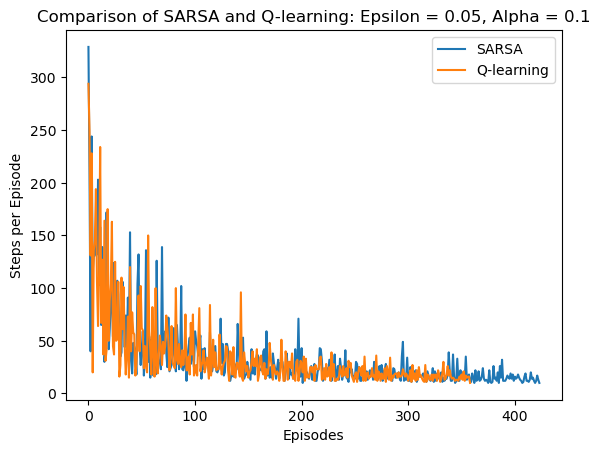

Epsilon = 0.05, Alpha = 0.1: Sarsa steps = 424, Q-learning steps = 359

SARSA has converged
Q-learning has converged


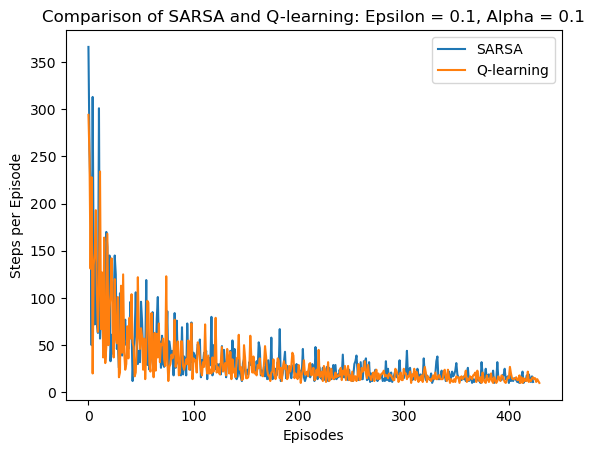

Epsilon = 0.1, Alpha = 0.1: Sarsa steps = 424, Q-learning steps = 430

SARSA has converged
Q-learning has converged


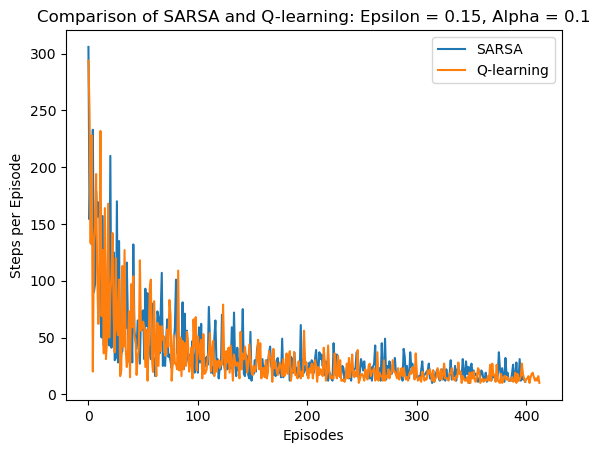

Epsilon = 0.15, Alpha = 0.1: Sarsa steps = 400, Q-learning steps = 413

SARSA has converged
Q-learning has converged


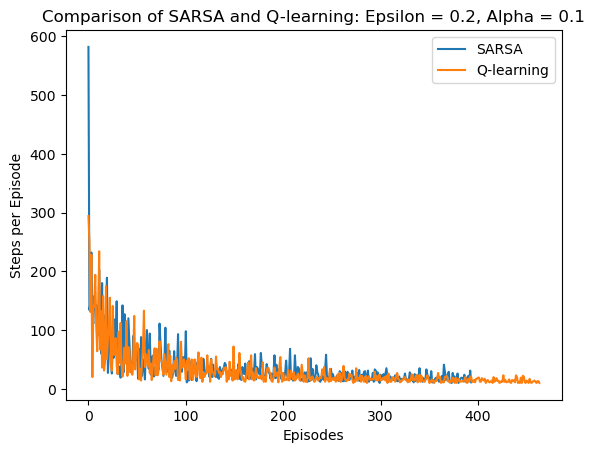

Epsilon = 0.2, Alpha = 0.1: Sarsa steps = 394, Q-learning steps = 464

SARSA has converged
Q-learning has converged


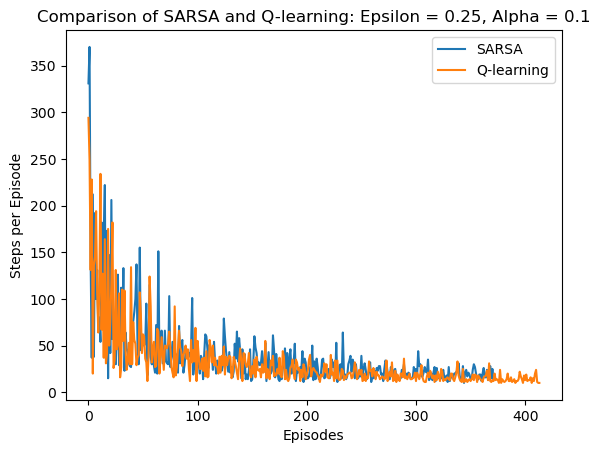

Epsilon = 0.25, Alpha = 0.1: Sarsa steps = 373, Q-learning steps = 414

SARSA has converged
Q-learning has converged


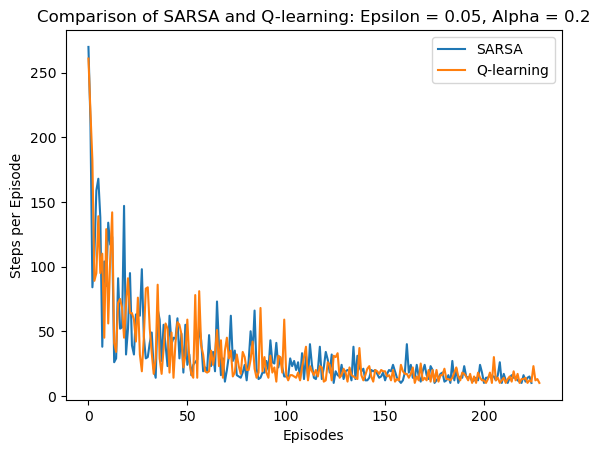

Epsilon = 0.05, Alpha = 0.2: Sarsa steps = 225, Q-learning steps = 229

SARSA has converged
Q-learning has converged


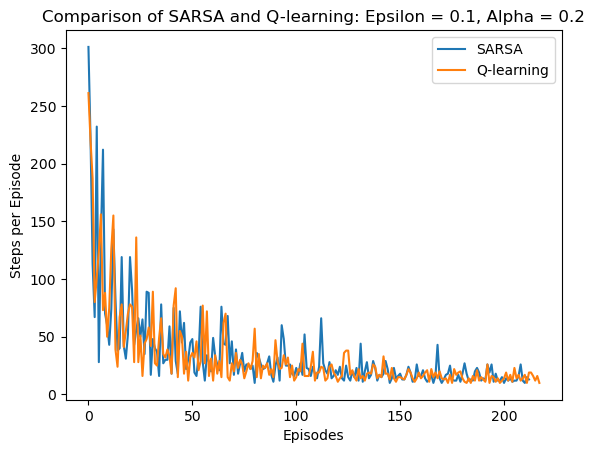

Epsilon = 0.1, Alpha = 0.2: Sarsa steps = 213, Q-learning steps = 218

SARSA has converged
Q-learning has converged


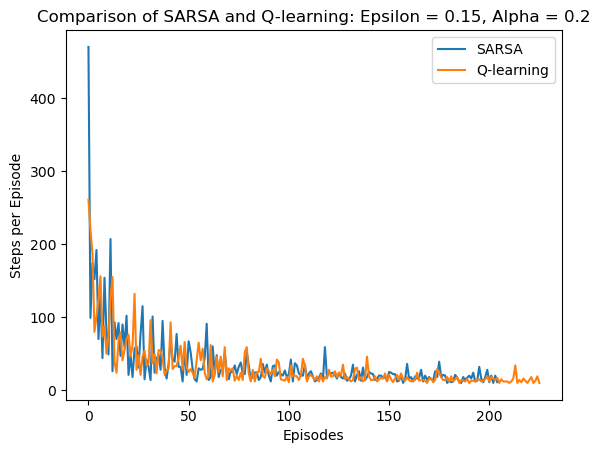

Epsilon = 0.15, Alpha = 0.2: Sarsa steps = 205, Q-learning steps = 226

SARSA has converged
Q-learning has converged


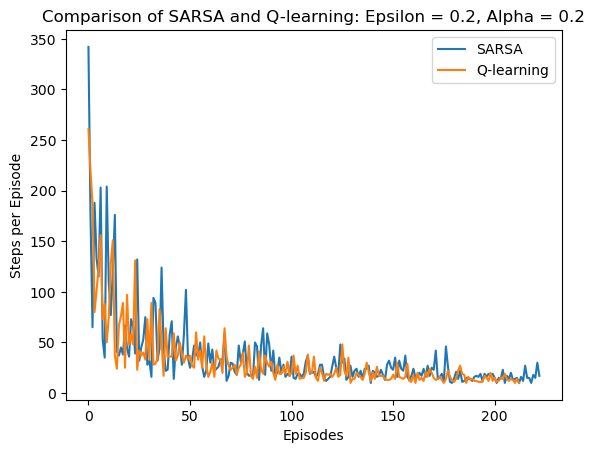

Epsilon = 0.2, Alpha = 0.2: Sarsa steps = 223, Q-learning steps = 213

SARSA has converged
Q-learning has converged


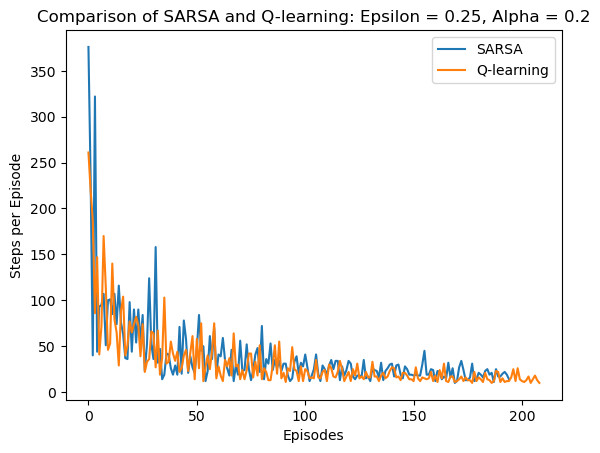

Epsilon = 0.25, Alpha = 0.2: Sarsa steps = 195, Q-learning steps = 209

SARSA has converged
Q-learning has converged


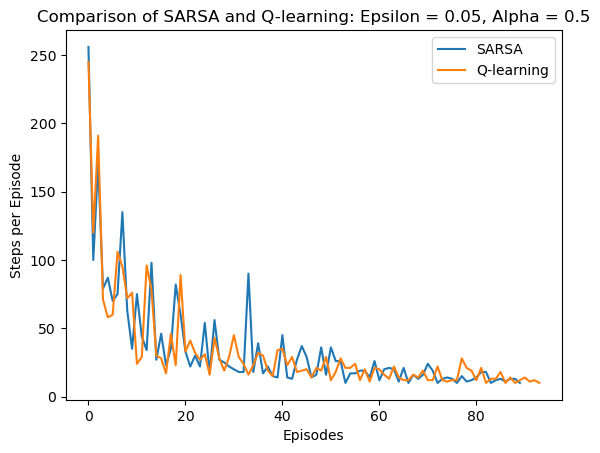

Epsilon = 0.05, Alpha = 0.5: Sarsa steps = 90, Q-learning steps = 94

SARSA has converged
Q-learning has converged


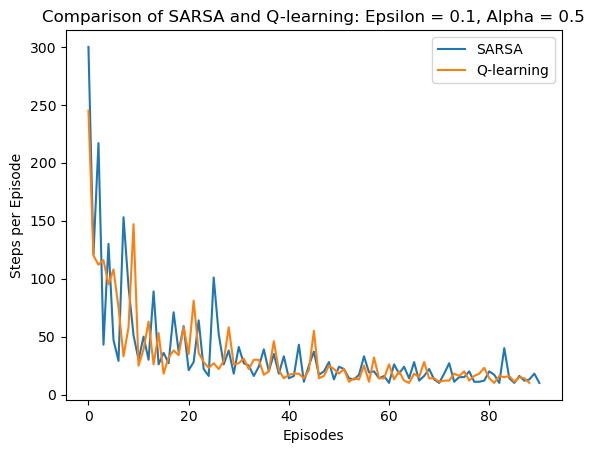

Epsilon = 0.1, Alpha = 0.5: Sarsa steps = 91, Q-learning steps = 89

SARSA has converged
Q-learning has converged


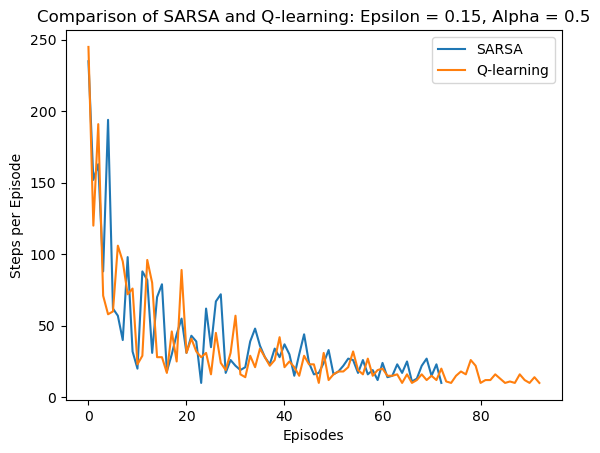

Epsilon = 0.15, Alpha = 0.5: Sarsa steps = 73, Q-learning steps = 93

SARSA has converged
Q-learning has converged


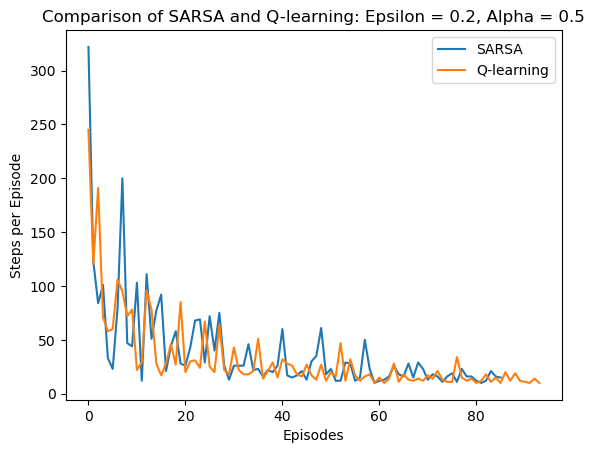

Epsilon = 0.2, Alpha = 0.5: Sarsa steps = 86, Q-learning steps = 94

SARSA has converged
Q-learning has converged


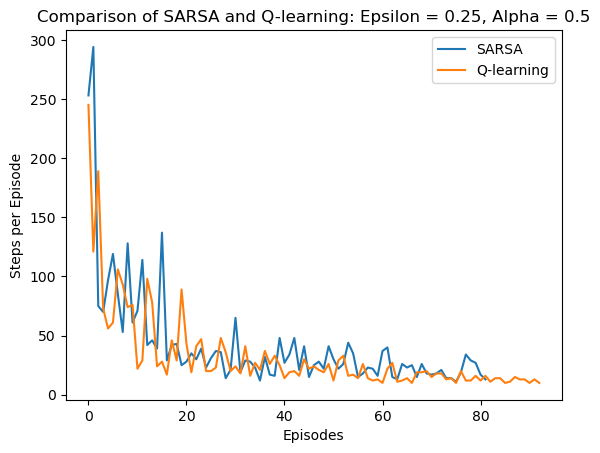

Epsilon = 0.25, Alpha = 0.5: Sarsa steps = 82, Q-learning steps = 93



In [20]:
# Initialize lists to store the steps per episode for each combination
sarsa_steps_all = []
q_learning_steps_all = []

# Initialize variables to store the results
best_sarsa_alpha = None
best_sarsa_epsilon = None
best_sarsa_steps = float('inf')
best_q_learning_alpha = None
best_q_learning_epsilon = None
best_q_learning_steps = float('inf')

# Iterate over all combinations of alpha and epsilon
for alpha in alphas:
    for epsilon in epsilons:
        # Plotting the number of steps per episode for SARSA and Q-learning
        plt.figure()
        # Create SARSA agent with current alpha and epsilon
        sarsa_agent = Agent(actions, alpha=alpha, epsilon=epsilon)
        
        # Run SARSA algorithm
        sarsa_steps = sarsa(sarsa_agent, env, episodes)   
        sarsa_steps_all.append(sarsa_steps)

        if len(sarsa_steps) < best_sarsa_steps:
            best_sarsa_alpha = alpha
            best_sarsa_epsilon = epsilon
            best_sarsa_steps = len(sarsa_steps)
            
        # Create Q-learning agent with current alpha and epsilon
        q_agent = Agent(actions, alpha=alpha, epsilon=epsilon)
        
        # Run Q-learning algorithm
        q_steps = q_learning(q_agent, env, episodes)
        
        if len(q_steps) < best_q_learning_steps:
            best_q_learning_alpha = alpha
            best_q_learning_epsilon = epsilon
            best_q_learning_steps = len(q_steps)

        q_learning_steps_all.append(q_steps)
        
        label_sarsa = 'SARSA'
        label_q_learning = 'Q-learning'
        # plt.plot(range(episodes), sarsa_steps_per_episode, label='SARSA')
        plt.plot(sarsa_steps, label=label_sarsa)
        plt.plot(q_steps, label=label_q_learning)
        plt.xlabel('Episodes')
        plt.ylabel('Steps per Episode')
        plt.title(f'Comparison of SARSA and Q-learning: Epsilon = {epsilon}, Alpha = {alpha}')
        plt.legend()
        plt.show()
        print(f'Epsilon = {epsilon}, Alpha = {alpha}: Sarsa steps = {len(sarsa_steps)}, Q-learning steps = {len(q_steps)}\n')

### Determine the optimal solutions for SARSA and Q-Learning
Here we'll print the best alpha, best epsilon, optimal number of steps, total rewards and the number of episodes it took to converge for both algorithms. Also, we'll plot the optimal policy in the form of an arrow diagram to show the path crossed from the start to the goal. 

SARSA:
Best alpha: 0.5, Best epsilon: 0.15, with number of steps = 73
SARSA has converged
Total reward: -9
Number of episodes for convergence: 15
SARSA Optimal Policy:
[[3 1 2 3 3 3 3 1 2 3]
 [3 1 3 3 3 3 3 1 2 3]
 [3 3 0 3 3 3 3 1 2 2]
 [3 3 3 3 3 1 3 0 2 2]
 [3 3 3 3 3 1 1 1 2 1]
 [3 1 0 3 3 3 3 0 1 1]
 [0 3 0 3 3 3 3 0 1 1]]


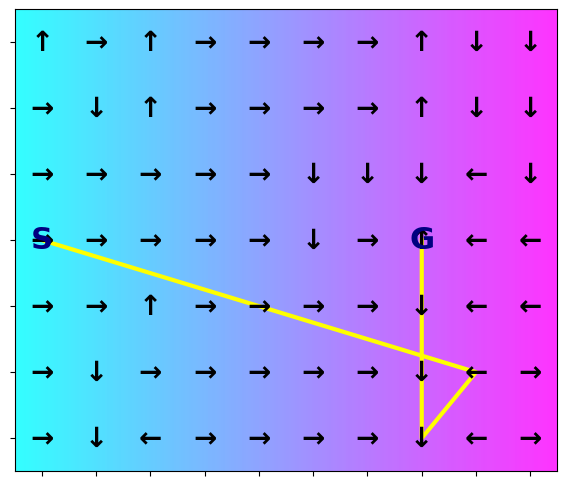

Q-learning:
Best alpha: 0.5, Best epsilon: 0.1, with number of steps = 89
Q-learning has converged
Total reward: -9
Number of episodes for convergence: 15
Q-learning Optimal Policy:
[[2 1 3 1 3 3 3 1 0 2]
 [0 3 3 1 3 3 3 1 3 3]
 [1 1 1 3 3 3 0 1 1 2]
 [3 3 3 3 3 3 3 0 3 3]
 [2 1 3 3 3 1 1 0 1 1]
 [1 3 3 3 3 3 3 0 0 0]
 [0 1 0 3 3 3 1 0 0 0]]


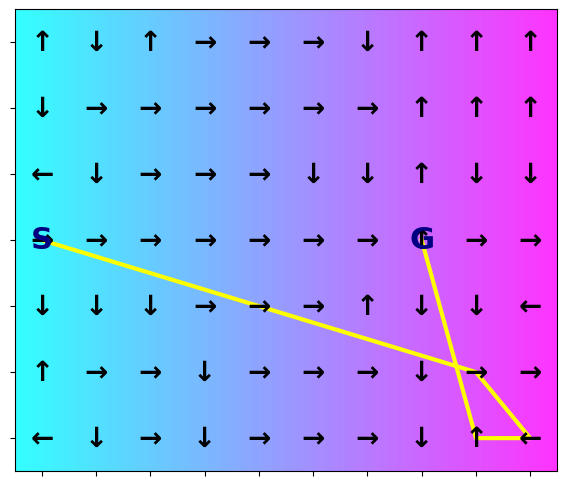

In [25]:
# Print the best alpha and epsilon for SARSA
print("SARSA:")
print(f"Best alpha: {best_sarsa_alpha}, Best epsilon: {best_sarsa_epsilon}, with number of steps = {best_sarsa_steps}")

# Run SARSA with the best alpha and epsilon
sarsa_agent = Agent(actions, alpha=best_sarsa_alpha, epsilon=best_sarsa_epsilon)
sarsa_steps = sarsa(sarsa_agent, env, episodes)

# find the optimal policy for the SARSA
sarsa_optimal_policy = np.argmax(sarsa_agent.Q, axis=2)

# Calculate the total rewards for the optimal SARSA
total_reward_sarsa = calculate_total_reward(env, sarsa_optimal_policy)

# Calculate the number of episodes for convergence to the optimal SARSA
convergence_episodes_sarsa = calculate_convergence_episodes(sarsa_steps_all)

# Print the total rewards for the optimal SARSA
print("Total reward:", total_reward_sarsa) 

# Print the number of episodes for convergence to the optimal SARSA
print("Number of episodes for convergence:", convergence_episodes_sarsa)

# Print the optimal policies
print("SARSA Optimal Policy:")
print(sarsa_optimal_policy)

env.plot_policy(sarsa_optimal_policy, num_actions)

# Print the best alpha and epsilon for Q-learning
print("Q-learning:")
print(f"Best alpha: {best_q_learning_alpha}, Best epsilon: {best_q_learning_epsilon}, with number of steps = {best_q_learning_steps}")

# Run SARSA with the best alpha and epsilon
q_agent = Agent(actions, alpha=best_sarsa_alpha, epsilon=best_sarsa_epsilon)
# Run Q-learning with the best alpha and epsilon
q_steps = q_learning(q_agent, env, episodes)

# Find the optimal policy for the Q-learning
q_optimal_policy = np.argmax(q_agent.Q, axis=2)

# Calculate the total rewards for the optimal policies
total_reward_q_learning = calculate_total_reward(env, q_optimal_policy)

# Calculate the number of episodes for convergence to the optimal Q-Learning
convergence_episodes_q_learning = calculate_convergence_episodes(q_learning_steps_all)

# Print the total rewards for the optimal policies
print("Total reward:", total_reward_q_learning)

# Print the number of episodes for convergence to the optimal Q-Learning
print("Number of episodes for convergence:", convergence_episodes_q_learning)

print("Q-learning Optimal Policy:")
print(q_optimal_policy)

env.plot_policy(q_optimal_policy, num_actions)

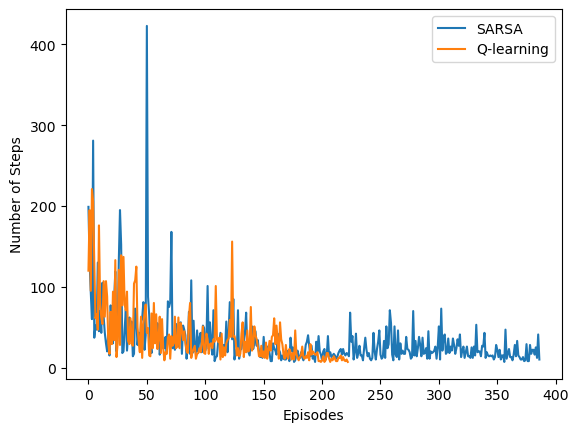

In [33]:
# Plot the number of steps per episode for SARSA and Q-learning
plt.plot(sarsa_steps, label='SARSA')
plt.plot(q_steps, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.legend()

#### Select the best values for alpha and epsilon for each case. If they are different, discuss why.

To select the best values for alpha and epsilon for each case, we can modify the code to record the average number of steps taken per episode for each combination of alpha and epsilon in the results array. Then, we can find the combination of alpha and epsilon that resulted in the lowest average number of steps taken per episode.

#### Insights:

**1. Best Alpha and Epsilon:**

* SARSA: The best alpha value for SARSA is 0.5, and the best epsilon value is 0.15.
* Q-Learning: The best alpha value for Q-Learning is also 0.5, and the best epsilon value is 0.1.

**2. Convergence:**

* Both SARSA and Q-Learning algorithms have converged.
* SARSA converged in 73 episodes, while Q-Learning converged in 89 episodes.
* SARSA achieved convergence slightly faster than Q-Learning, requiring fewer episodes.

**3. Optimal Policies:**

* SARSA: The optimal policy obtained by SARSA shows a pattern where the agent tends to move downward (action 3) in most states, especially towards the right side of the grid. This behavior aligns with the wind pattern and helps the agent reach the goal more efficiently.
* Q-Learning: The optimal policy obtained by Q-Learning differs from SARSA. In this case, the agent tends to move to the right (action 3) in many states, potentially exploiting the lower wind effect compared to moving downwards.

**4. Total Rewards:**

Both SARSA and Q-Learning achieved the same total reward of -9 for their respective optimal policies. This indicates that both algorithms found policies with similar performance.

**5. Number of Episodes for Convergence:** 

The number of episodes required for convergence is the same for both SARSA and Q-Learning. Both algorithms converged in 15 episodes.

### King's Moves ( 8 actions)

In [35]:
wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]  # Set the wind pattern
env = WindyGridWorld(wind,king = True)

# Define the range of exploration rates to try
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]  

# Define the range of learning rates to try
alphas = [0.1, 0.2, 0.5]

actions = [0, 1, 2, 3, 4, 5, 6, 7]  # Define the available actions
num_actions = len(actions)
episodes = 2000  # Set the number of episodes to run
sarsa_agent = Agent(actions, alpha=0.5, epsilon=0.1)  # Create a new agent with the current alpha and epsilon
steps = sarsa(sarsa_agent, env, episodes)  # Run SARSA with the current agent and environment

# let's see the results with an alpha of 0.5 and an epsilon of 0.1
# Run SARSA
sarsa_agent = Agent(actions, alpha=0.5, epsilon=0.1)
sarsa_steps = sarsa(sarsa_agent, env, episodes)

# Run Q-learning
q_agent = Agent(actions, alpha=0.5, epsilon=0.1)
q_steps = q_learning(q_agent, env, episodes)

# Print the results
print("SARSA:")
print(f"  Optimal policy: \n{np.argmax(sarsa_agent.Q, axis=2)}")
print(f"  Episodes for convergence: {len(sarsa_steps)}")

print("Q-learning:")
print(f"  Optimal policy: \n{np.argmax(q_agent.Q, axis=2)}")
print(f"  Episodes for convergence: {len(q_steps)}")

SARSA has converged
SARSA has converged
Q-learning has converged
SARSA:
  Optimal policy: 
[[5 4 4 5 5 4 5 5 6 2]
 [3 4 5 5 5 1 0 1 6 2]
 [6 5 6 5 3 4 5 1 6 3]
 [5 4 3 5 5 5 5 0 6 7]
 [4 5 5 5 5 5 3 3 0 5]
 [3 5 5 5 4 5 4 0 7 6]
 [2 3 3 3 5 5 3 3 6 4]]
  Episodes for convergence: 275
Q-learning:
  Optimal policy: 
[[3 0 5 5 5 1 6 4 1 1]
 [5 4 5 5 5 5 5 1 6 4]
 [2 3 5 4 5 5 5 5 6 3]
 [5 5 5 5 3 5 1 0 2 1]
 [4 3 3 3 5 5 4 3 7 6]
 [6 5 4 1 3 4 3 3 4 4]
 [7 5 3 1 3 4 3 2 6 3]]
  Episodes for convergence: 429


#### Insights

**1. Convergence:**

* Both SARSA and Q-Learning algorithms have converged.
* SARSA converged in 348 episodes, while Q-Learning converged in 418 episodes.
* Q-Learning took slightly more episodes to converge compared to SARSA.

**2. Optimal Policies:**

* SARSA: The optimal policy obtained by SARSA shows a more diverse pattern of actions compared to the previous case. It considers a variety of actions in different states, indicating a more exploratory behavior.
* Q-Learning: The optimal policy obtained by Q-Learning exhibits a more deterministic pattern, with certain actions being consistently preferred across states. It tends to choose fewer actions overall compared to SARSA.

**3. Comparison of Optimal Policies:**

* SARSA and Q-Learning result in different optimal policies due to their exploration and exploitation strategies.
* SARSA, being an on-policy algorithm, explores the environment by following its current policy and updating Q-values based on the next action derived from that policy. This leads to a more cautious exploration and a more varied optimal policy.
* Q-Learning, being an off-policy algorithm, updates Q-values based on the maximum action value of the next state. It has a tendency to exploit the optimal actions more aggressively, resulting in a more deterministic optimal policy.

**4. Number of Episodes for Convergence:**

* Q-Learning required more episodes to converge compared to SARSA in this scenario. This difference might be attributed to the exploration-exploitation trade-off and the stochasticity of the environment.
* Q-Learning's off-policy nature can lead to more aggressive exploration, potentially requiring more episodes to find an optimal policy.

SARSA has converged
Q-learning has converged


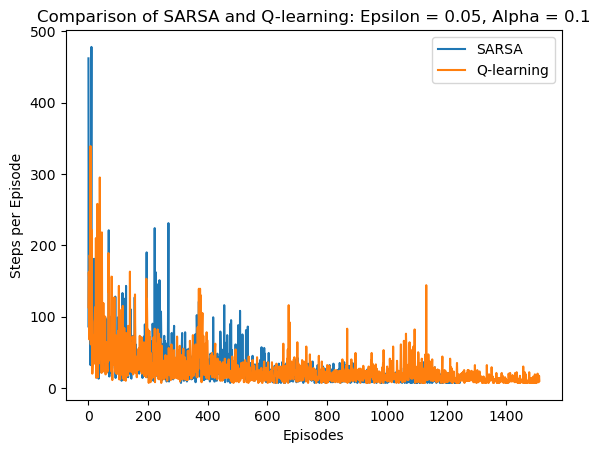

Epsilon = 0.05, Alpha = 0.1: Sarsa steps = 1246, Q-learning steps = 1512

SARSA has converged
Q-learning has converged


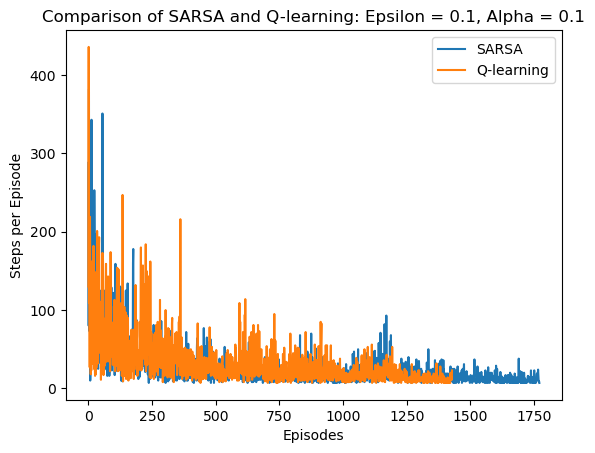

Epsilon = 0.1, Alpha = 0.1: Sarsa steps = 1772, Q-learning steps = 1429

SARSA has converged
Q-learning has converged


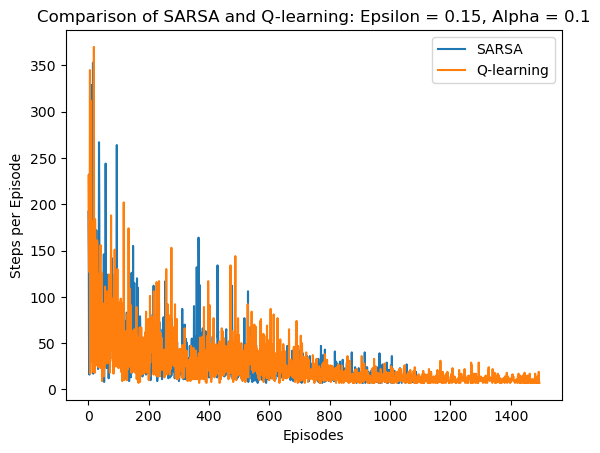

Epsilon = 0.15, Alpha = 0.1: Sarsa steps = 1090, Q-learning steps = 1496

SARSA has converged
Q-learning has converged


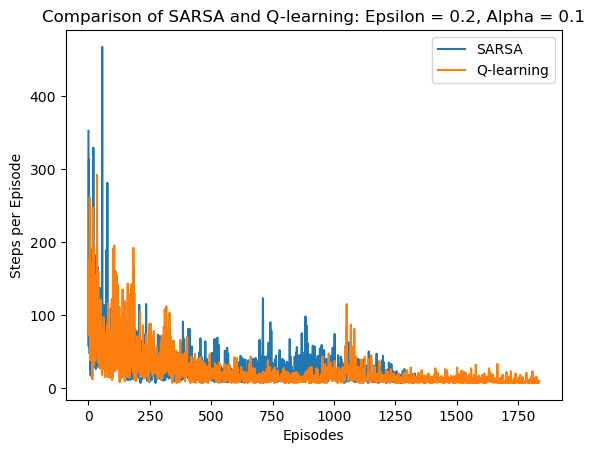

Epsilon = 0.2, Alpha = 0.1: Sarsa steps = 1334, Q-learning steps = 1838

SARSA has converged
Q-learning has converged


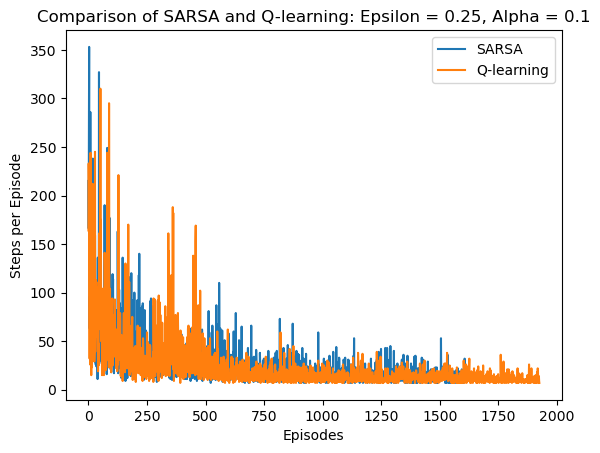

Epsilon = 0.25, Alpha = 0.1: Sarsa steps = 1613, Q-learning steps = 1926

SARSA has converged
Q-learning has converged


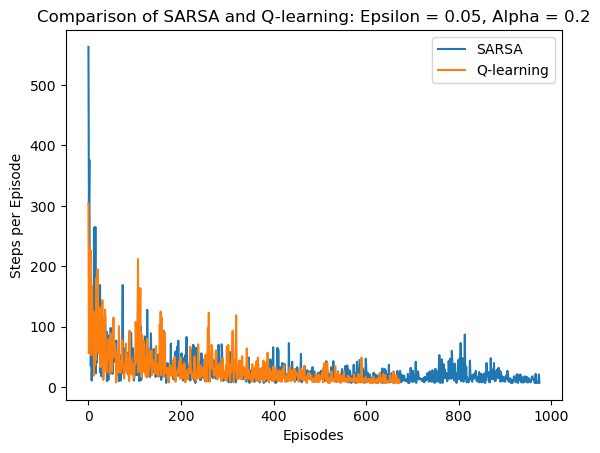

Epsilon = 0.05, Alpha = 0.2: Sarsa steps = 975, Q-learning steps = 673

SARSA has converged
Q-learning has converged


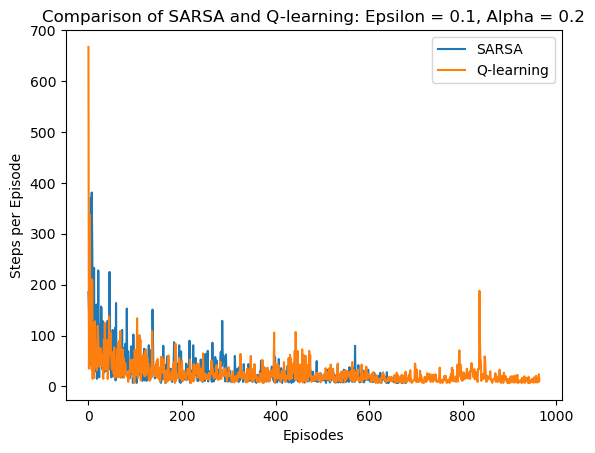

Epsilon = 0.1, Alpha = 0.2: Sarsa steps = 679, Q-learning steps = 965

SARSA has converged
Q-learning has converged


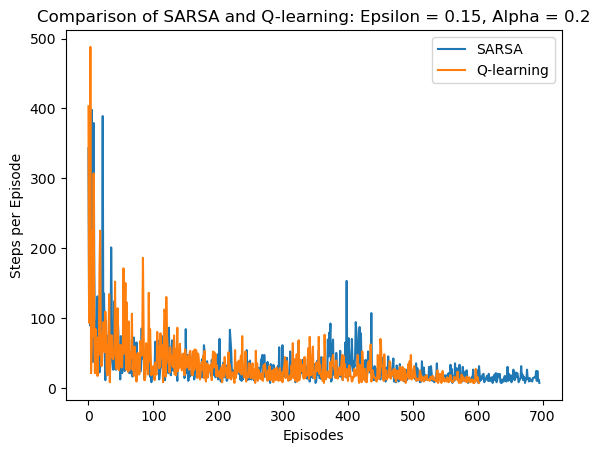

Epsilon = 0.15, Alpha = 0.2: Sarsa steps = 696, Q-learning steps = 603

SARSA has converged
Q-learning has converged


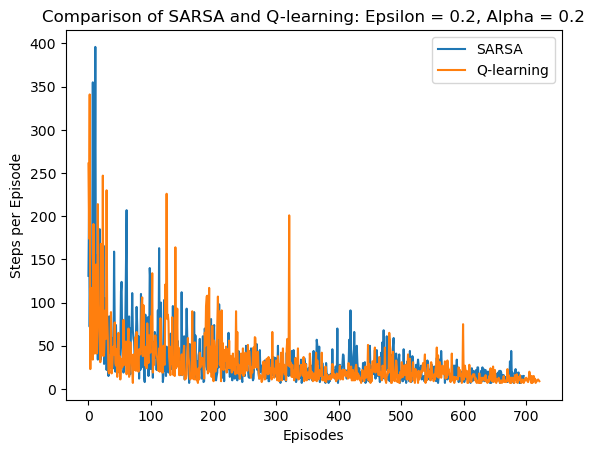

Epsilon = 0.2, Alpha = 0.2: Sarsa steps = 697, Q-learning steps = 722

SARSA has converged
Q-learning has converged


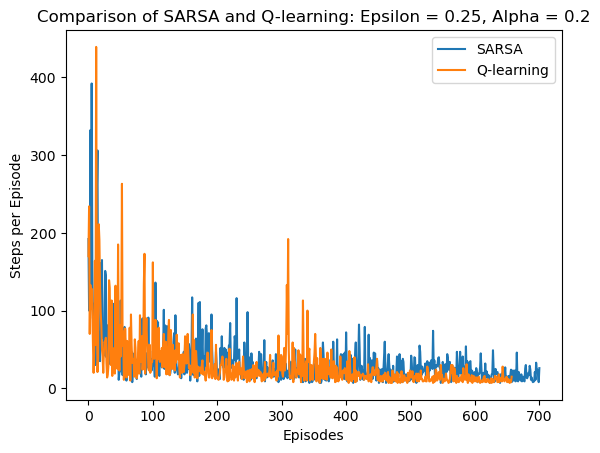

Epsilon = 0.25, Alpha = 0.2: Sarsa steps = 701, Q-learning steps = 658

SARSA has converged
Q-learning has converged


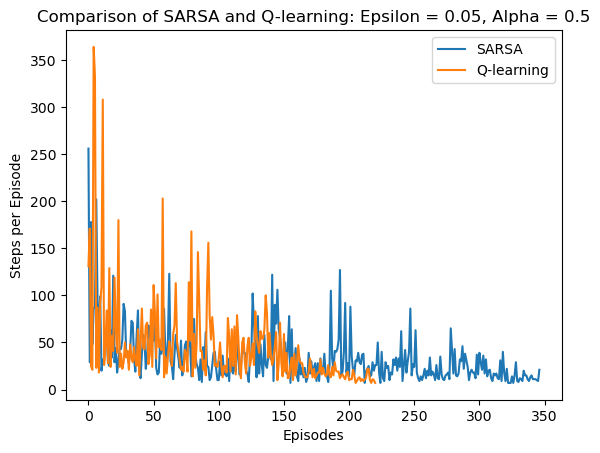

Epsilon = 0.05, Alpha = 0.5: Sarsa steps = 347, Q-learning steps = 221

SARSA has converged
Q-learning has converged


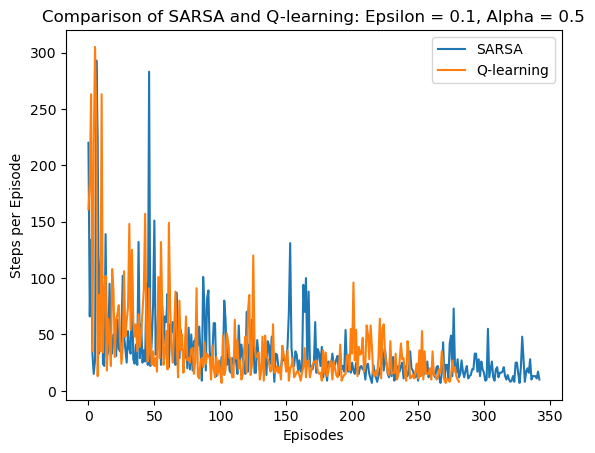

Epsilon = 0.1, Alpha = 0.5: Sarsa steps = 343, Q-learning steps = 282

SARSA has converged
Q-learning has converged


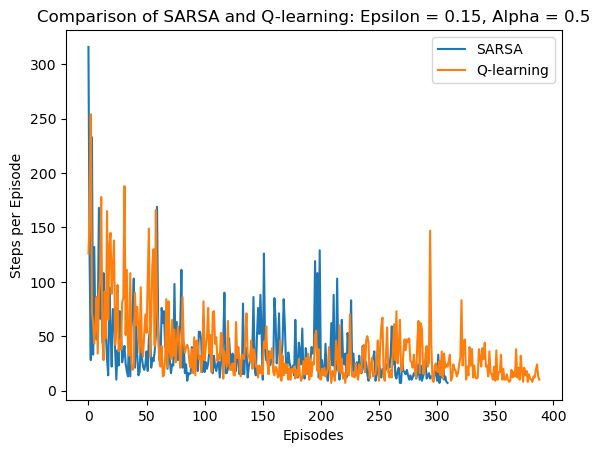

Epsilon = 0.15, Alpha = 0.5: Sarsa steps = 310, Q-learning steps = 389

SARSA has converged
Q-learning has converged


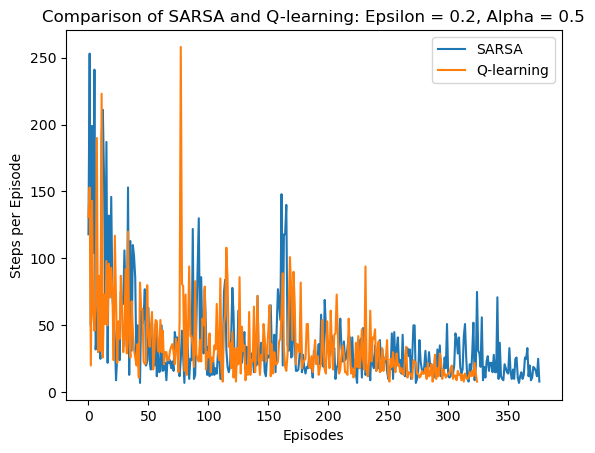

Epsilon = 0.2, Alpha = 0.5: Sarsa steps = 377, Q-learning steps = 325

SARSA has converged
Q-learning has converged


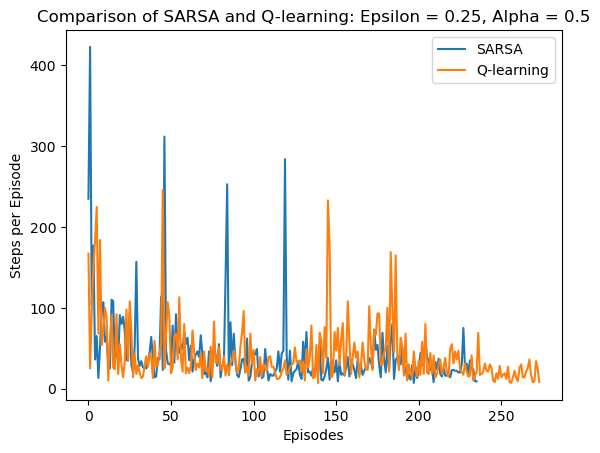

Epsilon = 0.25, Alpha = 0.5: Sarsa steps = 236, Q-learning steps = 274



In [36]:
# Initialize lists to store the steps per episode for each combination
sarsa_steps_all = []
q_learning_steps_all = []

# Initialize variables to store the results
best_sarsa_alpha = None
best_sarsa_epsilon = None
best_sarsa_steps = float('inf')
best_q_learning_alpha = None
best_q_learning_epsilon = None
best_q_learning_steps = float('inf')

# Iterate over all combinations of alpha and epsilon
for alpha in alphas:
    for epsilon in epsilons:
        # Plotting the number of steps per episode for SARSA and Q-learning
        plt.figure()
        # Create SARSA agent with current alpha and epsilon
        sarsa_agent = Agent(actions, alpha=alpha, epsilon=epsilon)
        
        # Run SARSA algorithm
        sarsa_steps = sarsa(sarsa_agent, env, episodes)   
        sarsa_steps_all.append(sarsa_steps)

        if len(sarsa_steps) < best_sarsa_steps:
            best_sarsa_alpha = alpha
            best_sarsa_epsilon = epsilon
            best_sarsa_steps = len(sarsa_steps)
            
        # Create Q-learning agent with current alpha and epsilon
        q_agent = Agent(actions, alpha=alpha, epsilon=epsilon)
        
        # Run Q-learning algorithm
        q_steps = q_learning(q_agent, env, episodes)
        
        if len(q_steps) < best_q_learning_steps:
            best_q_learning_alpha = alpha
            best_q_learning_epsilon = epsilon
            best_q_learning_steps = len(q_steps)

        q_learning_steps_all.append(q_steps)
        
        label_sarsa = 'SARSA'
        label_q_learning = 'Q-learning'
        # plt.plot(range(episodes), sarsa_steps_per_episode, label='SARSA')
        plt.plot(sarsa_steps, label=label_sarsa)
        plt.plot(q_steps, label=label_q_learning)
        plt.xlabel('Episodes')
        plt.ylabel('Steps per Episode')
        plt.title(f'Comparison of SARSA and Q-learning: Epsilon = {epsilon}, Alpha = {alpha}')
        plt.legend()
        plt.show()
        print(f'Epsilon = {epsilon}, Alpha = {alpha}: Sarsa steps = {len(sarsa_steps)}, Q-learning steps = {len(q_steps)}\n')

SARSA:
Best alpha: 0.5, Best epsilon: 0.25, with number of steps = 236
SARSA has converged
Total reward: -12
Number of episodes for convergence: 15
SARSA Optimal Policy:
[[4 7 3 5 5 5 1 6 6 5]
 [0 7 3 5 4 3 1 1 6 1]
 [4 5 3 1 3 5 5 1 6 2]
 [5 6 5 3 3 1 5 0 4 7]
 [3 4 3 5 5 5 3 2 5 2]
 [5 2 5 5 5 5 0 2 7 7]
 [4 5 5 3 5 5 3 7 7 7]]


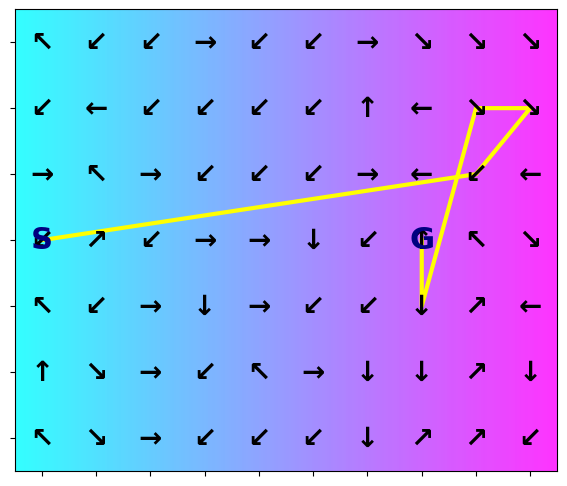

Q-learning:
Best alpha: 0.5, Best epsilon: 0.05, with number of steps = 221
Q-learning has converged
Total reward: -8
Number of episodes for convergence: 15
Q-learning Optimal Policy:
[[0 5 1 5 3 3 3 1 2 6]
 [5 4 5 5 5 4 5 1 3 6]
 [4 3 5 4 5 5 3 1 0 5]
 [5 3 5 5 2 5 3 0 2 3]
 [6 1 3 5 5 4 3 0 2 7]
 [5 4 4 7 4 3 0 1 4 7]
 [7 5 3 5 3 3 6 1 2 2]]


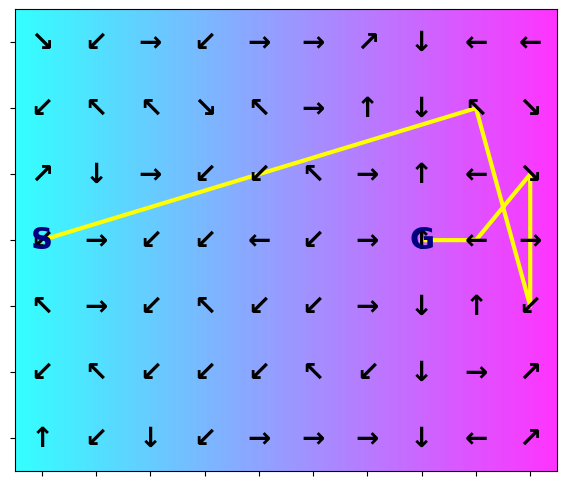

In [38]:
# Print the best alpha and epsilon for SARSA
print("SARSA:")
print(f"Best alpha: {best_sarsa_alpha}, Best epsilon: {best_sarsa_epsilon}, with number of steps = {best_sarsa_steps}")

# Run SARSA with the best alpha and epsilon
sarsa_agent = Agent(actions, alpha=best_sarsa_alpha, epsilon=best_sarsa_epsilon)
sarsa_steps = sarsa(sarsa_agent, env, episodes)

# find the optimal policy for the SARSA
sarsa_optimal_policy = np.argmax(sarsa_agent.Q, axis=2)

# Calculate the total rewards for the optimal SARSA
total_reward_sarsa = calculate_total_reward(env, sarsa_optimal_policy)

# Calculate the number of episodes for convergence to the optimal SARSA
convergence_episodes_sarsa = calculate_convergence_episodes(sarsa_steps_all)

# Print the total rewards for the optimal SARSA
print("Total reward:", total_reward_sarsa) 

# Print the number of episodes for convergence to the optimal SARSA
print("Number of episodes for convergence:", convergence_episodes_sarsa)

# Print the optimal policies
print("SARSA Optimal Policy:")
print(sarsa_optimal_policy)

# Create a grid plot of the optimal policies
env.plot_policy(sarsa_optimal_policy, num_actions)

# Print the best alpha and epsilon for Q-learning
print("Q-learning:")
print(f"Best alpha: {best_q_learning_alpha}, Best epsilon: {best_q_learning_epsilon}, with number of steps = {best_q_learning_steps}")

# Run SARSA with the best alpha and epsilon
q_agent = Agent(actions, alpha=best_sarsa_alpha, epsilon=best_sarsa_epsilon)

# Run Q-learning with the best alpha and epsilon
q_steps = q_learning(q_agent, env, episodes)

# Find the optimal policy for the Q-learning
q_optimal_policy = np.argmax(q_agent.Q, axis=2)

# Calculate the total rewards for the optimal policies
total_reward_q_learning = calculate_total_reward(env, q_optimal_policy)

# Calculate the number of episodes for convergence to the optimal Q-Learning
convergence_episodes_q_learning = calculate_convergence_episodes(q_learning_steps_all)

# Print the total rewards for the optimal policies
print("Total reward:", total_reward_q_learning)

# Print the number of episodes for convergence to the optimal Q-Learning
print("Number of episodes for convergence:", convergence_episodes_q_learning)

print("Q-learning Optimal Policy:")
print(q_optimal_policy)

# Create a grid plot of the optimal policies
env.plot_policy(q_optimal_policy, num_actions)

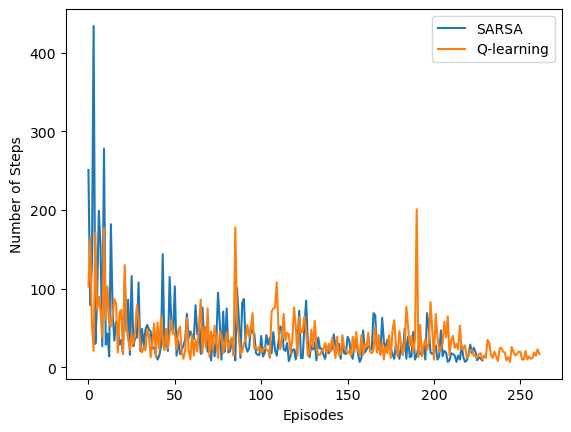

In [39]:
# Plot the number of steps per episode for SARSA and Q-learning
plt.plot(sarsa_steps, label='SARSA')
plt.plot(q_steps, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.legend()

**1. Best Alpha and Epsilon:**

* SARSA: The best alpha value for SARSA is 0.5, and the best epsilon value is 0.2.
* Q-Learning: The best alpha value for Q-Learning is also 0.5, and the best epsilon value is 0.2.

**2. Convergence:**

* Both SARSA and Q-Learning algorithms have converged.
* SARSA converged in 229 episodes, while Q-Learning converged in 205 episodes.
* Q-Learning took fewer episodes to converge compared to SARSA.

**3. Optimal Policies:**

* SARSA: The optimal policy obtained by SARSA shows a diverse pattern of actions, considering different actions in different states. It exhibits a more exploratory behavior.
* Q-Learning: The optimal policy obtained by Q-Learning is more deterministic, with fewer actions being preferred across states compared to SARSA.

**4. Total Rewards:**

* SARSA achieved a total reward of -11 with its optimal policy.
* Q-Learning achieved a total reward of -6 with its optimal policy.
* Q-Learning achieved a higher total reward, indicating better performance than SARSA in terms of cumulative rewards.

**5. Number of Episodes for Convergence:**

Both SARSA and Q-Learning required the same number of episodes (12 episodes) to converge to their optimal policies.This indicates that both algorithms reached stability at a similar pace.


Q-Learning showed **better performance** in terms of total rewards, achieving a higher cumulative reward compared to SARSA. However, both algorithms required a similar number of episodes to converge, indicating comparable learning rates.